In [283]:
import numpy as np
import time
import copy
from scipy.io import loadmat
import pandas as pd 
import matplotlib.pyplot as plt
import csv

In [286]:
rawxycentroidData = (loadmat('C:\\Users\\Abin\\Desktop\\Part4\\Research\\Development\\Kalman\\2peoplecentroidData.mat'))['data'][0]

In [287]:
def readMeasurements():
    #read in measurements from csv
    rawCentroidData = pd.read_csv('2PeopleCentroids.csv', header=None)
    #find headers and frames within headers
    #each header has the structure X, Y, CentroidNumber
    #below each header is the frame data
    centroidFramesCartesianMeasurement = list()
    headerFound = False
    for rowIndex in range(0, rawCentroidData.shape[0]):
        row = rawCentroidData.loc[rowIndex]
        if row[0] == 'X' and row[1] == 'Y' and row[2] == 'CentroidNumber':
            if headerFound: 
                #actual data was found last frame and this frame actual data is found again
                #past frame ended so add to list
                centroidFramesCartesianMeasurement.append(frame)
                frame = pd.DataFrame([])
            else:
                #header found
                headerFound = True
                frame = pd.DataFrame([])
            #data should be following
        elif headerFound:
            if np.isnan(np.float(row[0])) and np.isnan(np.float(row[1])):
                #empty row 
                centroidFramesCartesianMeasurement.append(frame)
                headerFound = False
                #only time its going to be NaN if the frame is completely empty
            else:
                #actual data
                X = np.float(row[0])
                Y = np.float(row[1])
                CentroidNumber = int(row[2])
                if len(frame) == 0:
                    frame = pd.DataFrame({'X':X, 'Y':Y, 'CentroidNumber':CentroidNumber}, index=range(1))
                else:
                    data = pd.DataFrame({'X':X, 'Y':Y, 'CentroidNumber':CentroidNumber}, index=range(CentroidNumber,CentroidNumber+1))
                    frame = pd.concat([frame,data])
    
    return centroidFramesCartesianMeasurement

In [294]:
centroidFramesCartesianMeasurement1.value[1]

NameError: name 'centroidFramesCartesianMeasurement1' is not defined

In [95]:
def predict(x, P, A, Q): #predict function
    xpred = np.matmul(A,x)
    Ppred = np.matmul(A,P)
    Ppred = np.matmul(Ppred,np.transpose(A)) + Q
    return(xpred, Ppred)

In [96]:
def innovation(xpred, Ppred, z, H, R): #innovation function
    nu = z - np.matmul(H,xpred)
    S = np.matmul(H,Ppred)
    S = R + np.matmul(S, np.transpose(H))
    return(nu, S)

In [97]:
def innovation_update(xpred, Ppred, nu, S, H):
    K = np.matmul(Ppred, np.transpose(H))
    K = np.matmul(K,np.linalg.inv(S)) #check inverse function
    xnew = xpred + np.matmul(K,nu)
    Pnew = np.matmul(K,S)
    Pnew = Ppred - np.matmul(Pnew,np.transpose(K)) 
    return(xnew, Pnew)

In [98]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [54]:
#Unit Tests
centroidPred1 = np.array([[4.3],[1.834208727]])
centroidPred2 = np.array([[4.4],[1.334208727]])
centroidPred = np.hstack((centroidPred1,centroidPred2))
rthetacentroid = np.array([[1.1],[0.2167122356]])
rthetacentroid3 = np.array([[4],[1.834208727]])
rthetacentroid4 = np.array([[2.2],[2.156221867]])
#rthetacentroid = np.hstack((rthetacentroid1,rthetacentroid3))
#rthetacentroid = np.hstack((rthetacentroid5,rthetacentroid4))
centroidPred = np.vstack((centroidPred,centroidPred))
print(centroidPred)
print(rthetacentroid)



[[4.3        4.4       ]
 [1.83420873 1.33420873]
 [4.3        4.4       ]
 [1.83420873 1.33420873]]
[[1.1       ]
 [0.21671224]]


In [55]:
#associate function

def data_associate(centroidPred, rthetacentroid):
    rthetacentroidCurrent = rthetacentroid
    centpredCol = np.size(centroidPred,1)
    rthetaCol = np.size(rthetacentroid,1)

    for i in list(range(0,centpredCol)):
        r1 = centroidPred[0][i]
        r2 = rthetacentroid[0]
        theta1 = centroidPred[1][i] #HARDCODE: theta is 2nd index
        theta2 = rthetacentroid[1]
        temp = np.sqrt(np.multiply(r1,r1) + np.multiply(r2,r2) - np.multiply(np.multiply(np.multiply(2,r1),r2),np.cos(theta2-theta1)))
        if(i==0):
            minDist = temp
        else:
            minDist = np.vstack((minDist,temp))

    currentFrame = np.empty((2,max(centpredCol,rthetaCol)))
    currentFrame[:] = np.nan

    minDist = np.reshape(minDist, (centpredCol,rthetaCol))
    minDistOrg = minDist
    print(minDist)

    for i in list(range(0,min(centpredCol,rthetaCol))):
        if((np.ndim(minDist)) == 1):
            minDist = np.reshape(minDist,(rthetaCol,1))
            minDistOrg = np.reshape(minDistOrg,(rthetaCol,1))
        val = np.min(minDist)
        resultOrg = np.argwhere(minDistOrg == val)
        result = np.argwhere(minDist == val)
        minRowOrg = resultOrg[0][0]
        minColOrg = resultOrg[0][1]
        minRow = result[0][0]
        minCol = result[0][1]
        currentFrame[:,minRowOrg] = rthetacentroid[:,minColOrg]
        minDist = np.delete(minDist,minRow,0)
        minDist = np.delete(minDist,minCol,1)
        rthetacentroidCurrent = np.delete(rthetacentroidCurrent,minCol,1)
    index = 0

    if (rthetacentroidCurrent.size != 0):
        for i in list(range(centpredCol,rthetaCol)):
            currentFrame[:,i] = rthetacentroidCurrent[:,index]
            index += 1 

    return(currentFrame)

currentFrame = data_associate(centroidPred,rthetacentroid )
print(currentFrame)

[[4.48794196]
 [4.04113773]]
[[       nan 1.1       ]
 [       nan 0.21671224]]


In [100]:
#initialise matrices 
centroidX =np.zeros((4,1))
delT = 0.0500
A = np.array([[1,delT,0,0], [0,1,0,0], [0,0,1,delT], [0,0,0,1]])
H = np.array([[1,0,0,0],[0,0,1,0]])
P = np.identity(4);
Q = np.multiply(0.9,np.identity(4))
R = np.array([[1],[1]])
print(R)

[[1]
 [1]]


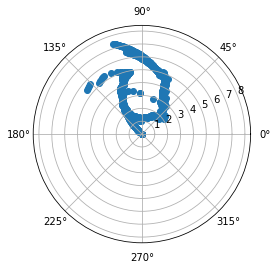

In [101]:
plt.figure()
theta = []
radius = []
ax = plt.subplot(111, projection='polar')
for currentrawxycentroidData in rawxycentroidData:
    
    xytransposecentroidData = np.transpose(currentrawxycentroidData) #Tranposed
    rthetacentroidData=xytransposecentroidData
    if (xytransposecentroidData.size != 0): 
        [rthetacentroidData[0,:],rthetacentroidData[1,:]] = cart2pol(xytransposecentroidData[0,:],xytransposecentroidData[1,:])
       # print(rthetacentroidData)
    if((rthetacentroidData.size != 0)):
        currentFrame = data_associate(centroidX, rthetacentroidData)
        
        addittionalCentroids = (np.size(rthetacentroidData,1)-np.size(centroidX,1))
        if(addittionalCentroids>0):
            centroidX = np.pad(centroidX, ((0,0),(0,addittionalCentroids)), 'constant') #initialises previous iteration to zer
                           
        for currentFrameIndex in list((range(0,np.size(currentFrame,1)))):
            if(not(np.isnan(currentFrame[0,currentFrameIndex]))):
                [xpred, Ppred] = predict(centroidX[:,currentFrameIndex], P, A, Q)
                [nu, S] = innovation(xpred, Ppred, currentFrame[:, currentFrameIndex], H, R)
                [centroidX[:,currentFrameIndex], P] = innovation_update(xpred, Ppred, nu, S, H)
            else:
                [centroidX[:,currentFrameIndex], Ppred] = predict(centroidX[:,currentFrameIndex], P, A, Q)
    else:
        for noFrameIndex in list((range(0,np.size(centroidX,1)))):
            [centroidX[:,noFrameIndex], Ppred] = predict(centroidX[:,noFrameIndex], P, A, Q)
    
    
    theta.append(centroidX[2][0])
    radius.append(centroidX[0][0])
#print(theta)    
ax.scatter(theta, radius)
plt.show()

In [231]:
centroidXTemp = np.zeros((4,(np.size(rthetacentroid,1)-np.size(centroidPred,1))))
test1 = np.pad(centroidPred, ((0,0),(0,0)), 'constant')
print(test1)
print(test1.shape)

[[4.3       ]
 [1.83420873]
 [4.3       ]
 [1.83420873]]
(4, 1)


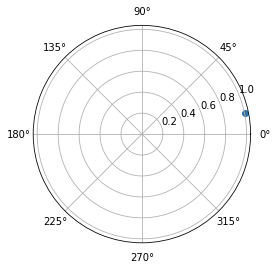

In [21]:
plt.figure()
ax = plt.subplot(111, projection='polar')
ax.scatter(theta, r)

In [34]:
P3 = []
P3.extend([P1])
P3.extend([P1])
print(P3)
print(len(P3))

[array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])]
2


In [12]:
P1 = np.identity(4)
P2 = 0.9*np.identity(4)

In [39]:
for i in list(range(0,1)):
    print(i)

0


In [202]:
result = []
np.reshape(2,0)

AttributeError: 'list' object has no attribute 'reshape'